In [ ]:
import os
import random
import numpy as np

import functools

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchtext import datasets
from torchtext.data import Field
from torchtext.data import BucketIterator


SEED = 241

In [ ]:
def seed_everything(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)

  if torch.cuda.is_available(): 
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [ ]:
import spacy

!python -m spacy download de --quiet
!python -m spacy download en --quiet

spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
def tokenize_de(text):
  return [token.text for token in spacy_de.tokenizer(text)]

def tokenize_en(text):
  return [token.text for token in spacy_en.tokenizer(text)]

In [ ]:
SRC = Field(lower=True,
            use_vocab=True, 
            sequential=True, 
            init_token='<sos>',
            eos_token='<eos>',
            batch_first=True,
            include_lengths=True,
            tokenize=tokenize_de)

TRG = Field(lower=True, 
            use_vocab=True,
            sequential=True,
            init_token='<sos>',
            eos_token='<eos>',
            batch_first=True,
            include_lengths=True,
            tokenize=tokenize_en)

In [ ]:
train_data, valid_data, test_data = datasets.Multi30k.splits(exts=('.de', '.en'),
                                                             fields=[('de', SRC), ('en', TRG)])

In [ ]:
SRC.build_vocab(train_data)
TRG.build_vocab(train_data)

In [ ]:
batch_size = 256
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_iterator = BucketIterator.splits((train_data,), batch_size=batch_size, device=device)[0]
valid_iterator = BucketIterator.splits((valid_data,), batch_size=batch_size, device=device)[0]
test_iterator = BucketIterator.splits((test_data,), batch_size=batch_size, device=device)[0]

In [ ]:
class Config:
  def __init__(self,
               vocab_size,
               emb_size,
               hidden_size,
               num_layers, 
               dropout, 
               pad_index,
               device):
    self.vocab_size = vocab_size
    self.emb_size = emb_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.dropout = dropout
    self.pad_index = pad_index
    self.device = device

In [ ]:
class Encoder(nn.Module):

  def __init__(self, config):
    super().__init__()
    self.embedding = nn.Embedding(config.vocab_size,
                                  config.emb_size, 
                                  padding_idx=config.pad_index)
    self.dropout = nn.Dropout(config.dropout)
    self.rnn = nn.LSTM(config.emb_size,
                       config.hidden_size, 
                       config.num_layers, 
                       batch_first=True,
                       bidirectional=True,
                       dropout=config.dropout)
    self.fc = nn.Linear(2 * config.hidden_size, config.hidden_size)
    self.device = config.device

  def forward(self, text, text_lens):
    text_embedded = self.dropout(self.embedding(text))
    packed_sequence = nn.utils.rnn.pack_padded_sequence(text_embedded, 
                                                        text_lens,
                                                        batch_first=True, 
                                                        enforce_sorted=False)
    
    packed_outputs, (orig_hidden, cell) = self.rnn(packed_sequence)
    outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)

    hidden = torch.cat([orig_hidden[-1, :, :], orig_hidden[-2, :, :]], dim=1)
    hidden = torch.tanh(self.fc(hidden))

    return outputs, hidden

In [ ]:
class Attention(nn.Module):

  def __init__(self, enc_hidden_dim, dec_hidden_dim):
    super().__init__()
    self.enc_hidden_dim = enc_hidden_dim
    self.dec_hidden_dim = dec_hidden_dim
    self.attention = nn.Linear((2 * self.enc_hidden_dim) + self.dec_hidden_dim, self.dec_hidden_dim)
    self.v = nn.Linear(self.dec_hidden_dim, 1, bias=False)

  def forward(self, hidden, enc_outputs, mask):
    # hidden [bs, d_h_dim]
    # enc_outputs [bs, seq_len, 2 * e_h_dim]
    bs, seq_len, _ = enc_outputs.shape
    hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)
    # hidden [bs, seq_len, d_h_dim]
    # enc_outputs [bs, seq_len, 2 * e_h_dim]
    attn = torch.tanh(self.attention(torch.cat([hidden, enc_outputs], dim=2)))
    # attn [bs, seq_len, d_h_dim]
    energy = self.v(attn)
    # energy [bs, seq_len, 1]
    energy = energy.squeeze(2)
    # energy [bs, seq_len]
    energy = energy.masked_fill(mask == 0, -1e6)
    return F.softmax(energy, dim=1)

In [ ]:
class Decoder(nn.Module):

  def __init__(self, config, attention, enc_hidden_size):
    super().__init__()
    self.embedding = nn.Embedding(config.vocab_size, 
                                  config.emb_size, 
                                  padding_idx=config.pad_index)
    self.dropout = nn.Dropout(config.dropout)
    self.rnn = nn.GRU(config.emb_size + 2 * enc_hidden_size,
                       config.hidden_size,
                       config.num_layers,
                       batch_first=True, 
                       dropout=config.dropout if config.num_layers > 1 else 0)
    self.device = config.device
    self.output_dim = config.vocab_size
    self.attention = attention
    self.enc_hidden_size = enc_hidden_size
    self.output = nn.Linear(config.hidden_size + config.emb_size + (2 * enc_hidden_size), config.vocab_size)

  def forward(self, trg_input, hidden, enc_outputs, mask):
    trg_input = trg_input.unsqueeze(1)
    # trg_input [bs, 1]
    text_embedded = self.dropout(self.embedding(trg_input))
    # text_embedded [bs, 1, emb_dim]

    attn = self.attention(hidden, enc_outputs, mask)
    # attn [bs, seq_len]
    attn = attn.unsqueeze(1)
    # attn [bs, 1, seq_len]
    # enc_outputs [bs, seq_len, 2 * e_h_dim]
    weights = torch.bmm(attn, enc_outputs)
    # weights [bs, 1, 2 * e_h_dim]
    rnn_input = torch.cat([text_embedded, weights], dim=2)
    # rnn_input [bs, 1, 2 * e_h_dim + emb_dim]
    hidden = hidden.unsqueeze(0)
    # hidden [1, bs, h_dim]
    outputs, hidden = self.rnn(rnn_input, hidden)
    # outputs [bs, 1, d_h_dim]
    # hidden_orig [1, bs, d_h_dim]
    hidden = hidden.squeeze(0)
    text_embedded = text_embedded.squeeze(1)
    weights = weights.squeeze(1)

    outputs = torch.cat([hidden, text_embedded, weights], dim=1)
    # outputs [bs, 1, d_h_dim + emb_size + 2 * e_h_dim]
    return self.output(outputs), hidden, attn

In [ ]:
class Seq2Seq(nn.Module):

  def __init__(self, encoder, decoder, device):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.device = device

  def _create_mask(self, src_text_lens):
    bs = src_text_lens.size(0)
    max_src_seq_len = torch.max(src_text_lens)
    mask = torch.zeros(bs, max_src_seq_len)
    for i in range(bs):
      mask[i, :src_text_lens[i]] = 1
    return mask

  def forward(self, 
              src_text,
              src_text_len,
              trg_text,
              trg_text_len,
              teacher_forcing_ratio=0.5):
    
    enc_outputs, hidden = self.encoder(src_text, src_text_len)
    bs, seq_len = trg_text.shape
    dec_output_dim = decoder.output_dim
    mask = self._create_mask(src_text_len)
    mask = mask.to(self.device)

    outputs = torch.zeros(bs, seq_len, dec_output_dim).to(self.device)

    trg_input = trg_text[:, 0]

    for t in range(1, seq_len):
      prediction, hidden, attn = decoder(trg_input, hidden, enc_outputs, mask)

      outputs[:, t, :] = prediction

      top1 = torch.argmax(prediction, dim=1)
      teacher_force = random.random() < teacher_forcing_ratio
      next_token = trg_text[:, t]

      trg_input = next_token if teacher_force else top1
    return outputs

In [ ]:
encoder_config = Config(vocab_size=len(SRC.vocab),
                        emb_size=512,
                        hidden_size=256,
                        num_layers=2,
                        dropout=0.3,
                        pad_index=SRC.vocab.stoi[SRC.pad_token],
                        device=device)

decoder_config = Config(vocab_size=len(TRG.vocab),
                        emb_size=512,
                        hidden_size=256,
                        num_layers=1,
                        dropout=0.3,
                        pad_index=TRG.vocab.stoi[TRG.pad_token],
                        device=device)

encoder = Encoder(encoder_config)
attention = Attention(encoder_config.hidden_size, decoder_config.hidden_size)
decoder = Decoder(decoder_config, attention, encoder_config.hidden_size)
seq2seq = Seq2Seq(encoder, decoder, device).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=decoder_config.pad_index).to(device)
optimizer = torch.optim.Adam(seq2seq.parameters())

In [ ]:
# with torch.no_grad():
#   for batch in train_iterator:
#     src_text, src_text_len = batch.de
#     trg_text, trg_text_len = batch.en

#     outputs = seq2seq(src_text, src_text_len, trg_text, trg_text_len)

In [ ]:
def train_epoch(model, iterator, optimizer, criterion, teacher_force=0.5):
  model.train()

  error = 0.
  for batch in iterator:
    optimizer.zero_grad()
    
    src_text, src_text_lens = batch.de
    src_text_lens = src_text_lens.cpu()
    trg_text, trg_text_lens = batch.en
    trg_text_lens = trg_text_lens.cpu()

    outputs = seq2seq(src_text, src_text_lens, trg_text, trg_text_lens, teacher_forcing_ratio=teacher_force)

    outputs = outputs[:, 1:, :]
    trg_text = trg_text[:, 1:]

    outputs = outputs.contiguous()
    trg_text = trg_text.contiguous()

    batch_size, seq_len, output_dim = outputs.shape

    outputs = outputs.view(-1, output_dim)
    trg_text = trg_text.view(-1)

    loss = criterion(outputs, trg_text)
    loss.backward()
    optimizer.step()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    error += loss.detach().cpu().numpy()

  return error / len(iterator)


def valid_epoch(model, iterator, criterion, teacher_force=0):
  model.eval()

  error = 0.
  with torch.no_grad():
    for batch in iterator:
      
      src_text, src_text_lens = batch.de
      src_text_lens = src_text_lens.cpu()
      trg_text, trg_text_lens = batch.en
      trg_text_lens = trg_text_lens.cpu()

      outputs = seq2seq(src_text, src_text_lens, trg_text, trg_text_lens, teacher_forcing_ratio=teacher_force)

      outputs = outputs[:, 1:, :]
      trg_text = trg_text[:, 1:]

      outputs = outputs.contiguous()
      trg_text = trg_text.contiguous()

      batch_size, seq_len, output_dim = outputs.shape

      outputs = outputs.reshape(-1, output_dim)
      trg_text = trg_text.view(-1)

      loss = criterion(outputs, trg_text)

      error += loss.detach().cpu().numpy()

  return error / len(iterator)

In [ ]:
for i in range(10):
  train_error = train_epoch(seq2seq, train_iterator, optimizer, criterion, teacher_force=0.5)
  valid_error = valid_epoch(seq2seq, valid_iterator, criterion, teacher_force=0)
  print(f'Epoch: {i + 1}, Train Error: {train_error}, Valid Error {valid_error}')

Epoch: 1, Train Error: 5.1230571646439405, Valid Error 5.045970320701599
Epoch: 2, Train Error: 4.186247896729854, Valid Error 4.4566733837127686
Epoch: 3, Train Error: 3.5171332944903457, Valid Error 4.0057761669158936
Epoch: 4, Train Error: 3.080598889735707, Valid Error 3.7955670952796936
Epoch: 5, Train Error: 2.771454248512, Valid Error 3.7355512976646423
Epoch: 6, Train Error: 2.5221352368070367, Valid Error 3.709387719631195
Epoch: 7, Train Error: 2.3107156418917474, Valid Error 3.696047782897949
Epoch: 8, Train Error: 2.199237852765803, Valid Error 3.6355701684951782
Epoch: 9, Train Error: 2.0383083538005224, Valid Error 3.6049570441246033
Epoch: 10, Train Error: 1.9273295559381183, Valid Error 3.6312490105628967


In [ ]:
# class LanguageModel:

#   def __init__(self):
#     self.key_sep = '&'
#     self._occurances = {}

#   def build(self, texts):
#     for text in texts:
#       self.update(text)

#   def update(self, text):
#     tokens = text.split()
#     for i in range(len(tokens) - 1):
#       key = f'{tokens[i]}{self.key_sep}{tokens[i + 1]}'
#       if key not in self._occurances:
#         self._occurances[key] = 1
#       else:
#         self._occurances[key] += 1
  
#   def get(self, word, next_word):
#     key = f'{word}{self.key_sep}{next_word}'
#     if key not in self._occurances:
#       return 0
#     else:
#       return self._occurances[key] / len(self._occurances)


# lang_model = LanguageModel()
# corpus = [' '.join(example.en) for example in train_data.examples]
# lang_model.build(corpus)

# lang_model.get(word='two', next_word='men')

In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50):
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token] 
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_len = torch.LongTensor([len(src_indexes)])
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = torch.ByteTensor([1.] * len(src_indexes)).to(device)
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [ ]:
index = 12

origin_sentence = ' '.join(train_data.examples[index].de)
target_sentence = ' '.join(train_data.examples[index].en)

print(target_sentence)
trg_tokens, attentions_scores = translate_sentence(origin_sentence, SRC, TRG, seq2seq, device)
if trg_tokens[-1] == TRG.eos_token:
  trg_tokens = trg_tokens[:-1]

translated = ' '.join(trg_tokens)
print(translated)

a black dog and a spotted dog are fighting
a black dog and a spotted dog fighting .


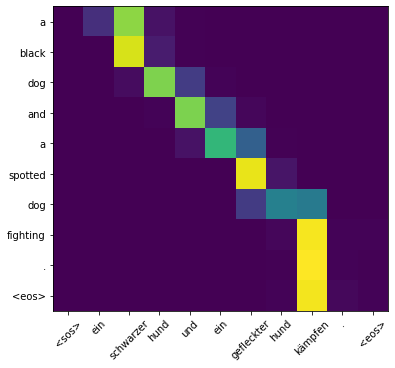

In [ ]:
from matplotlib import pyplot as plt


def show_attention(origin, translated, attention):  
    fig, ax = plt.subplots(figsize=(6, 6))
    
    attention = attention.squeeze(1).cpu().detach().numpy()

    origin = origin.split()
    translated = translated.split()

    ax.set_xticks(range(len(origin) + 2))
    ax.set_yticks(range(len(translated) + 1))

    ax.set_xticklabels(['<sos>'] + origin + ['<eos>'], rotation=45)
    ax.set_yticklabels(translated + ['<eos>'])

    ax.imshow(attention)


show_attention(origin_sentence, translated, attentions_scores)